## <span style="color:#40e0d0">**Analyze and Visualize Simulation Data**</span>

In [29]:
using LinearAlgebra
using Statistics
using Plots
using FFMPEG
using JSON
using HDF5

#=
length:km, mass:kg, time:s, angle:rad(deg in json)
(interval must be a multiple of dt, tEnd must be a multiple of interval)
=#

colors = [:orange, :black, :gold, :blue, :red, :brown, :bisque4, :gray, :blue] #惑星の色
AU = 1.495978e8 #AU
G = 6.67430e-20 #gravitational constant
NAMEINDEX = Dict(
    1 => "sun",
    2 => "mercury",
    3 => "venus",
    4 => "earth",
    5 => "mars",
    6 => "jupiter",
    7 => "saturn",
    8 => "uranus",
    9 => "neptune"
)

function plotAllWithChunks(plot::Plots.Plot, N::Int, file::HDF5.File, tEnd::Float64, dt::Float64, chunk_size::Int64, linestyle)
    Nt = Int(ceil(tEnd/dt))
    for c in 1:Int(Nt/chunk_size)
        chunk = read(file, "/data/$c")
        for i in 2:N
            X = chunk[i,1,:] ./ AU
            Y = chunk[i,2,:] ./ AU
            plot!(plot, X, Y, color=colors[i], lw=0.75, ls=linestyle)
        end
    end
    Xe = read(file, "/data/$(Int(Nt/chunk_size))")[:,1,end] ./ AU
    Ye = read(file, "/data/$(Int(Nt/chunk_size))")[:,2,end] ./ AU
    scatter!(plot, Xe, Ye, color=colors[1:N], markersize=3, marker_stroke=nothing, markerstrokewidth=0)
    return plot
end

function plotAllWithChunks(N::Int, file::HDF5.File, tEnd::Float64, dt::Float64, range::Float64, title, chunk_size::Int, linestyle)
    plot = scatter([], [], xlims=(-range,range), ylims=(-range,range), title=title, xlabel="x(au)", ylabel="y(au)", aspect_ratio=:equal, legend=false)
    return plotAllWithChunks(plot, N, file, tEnd, dt, chunk_size, linestyle)
end

function distanceOnSameTime(file1, file2, tEnd, dt, title, chunk_size, i1, i2)
    Nt = Int(ceil(tEnd/dt))
    num_chunks = Int(Nt/chunk_size)
    d = zeros(Nt) #risk of crash in case of the huge Nt
    #d = zeros((num_chunks, chunk_size))
    for c in 1:num_chunks
        chunk1 = read(file1, "/data/$c")[i1,:,:]
        chunk2 = read(file2, "/data/$c")[i2,:,:]
        d[(c-1)*chunk_size+1:c*chunk_size] = sum((chunk1 .- chunk2).^2, dims=1).^0.5
        #d[c,:] = sum((chunk1 .- chunk2).^2, dims=1).^0.5
    end

    p1 = plot(1:Nt, d, title=title, legend=false, xlabel="time(s)", ylabel="distance(km)")
    v = diff(d) ./ (2*dt)
    p2 = plot(1:Nt-1, v, title="Change of distance", legend=false, xlabel="time(s)", ylabel="change(km/s)")
    a = diff(v) ./ (2*dt)
    p3 = plot(1:Nt-2, a, title="Accelerate of distance", legend=false, xlabel="time(s)", ylabel="acc(km/s)")
    return p1, p2, p3
end

function scatterAll(N, file, tEnd, dt, range, interval, title, chunk_size)
    p = scatter([], [], xlims=(-range,range), ylims=(-range,range), title=title, xlabel="x", ylabel="y", aspect_ratio=:equal, legend=false)
    step = Int(interval / dt)
    Nt = Int(tEnd/dt)
    pos_save = zeros(N,3,Nt)
    for c in 1:Int(Nt/chunk_size)
        pos_save[:,:,(c-1)*chunk_size+1:c*chunk_size] = read(file, "/data/$c")
    end
    anim = @animate for frame in 1:Int(tEnd / interval)
        for i in 1:N
            x = pos_save[i,1,frame*step] / AU
            y = pos_save[i,2,frame*step] / AU
            scatter!(p, [x], [y], color=colors[i], markersize=0.5, marker_stroke=nothing, markerstrokewidth=0)
        end
    end

    return anim
end

function accByOthers(N, file, tEnd, dt, mass, title, chunk_size, target)
    planets_fill_color = [:snow3, :goldenrod2, :dodgerblue2, :firebrick, :goldenrod4, :wheat1, :paleturquoise1, :blue4, :black]

    p = plot(title=title, xlabel="time(days)", ylabel="acceleration(km/s^2)", dpi=300)
    Nt = Int(ceil(tEnd/dt))
    chunk = zeros(N,3,chunk_size) #allocate memory in advance
    accs_categorized = zeros((N, chunk_size))
    accs_sum = zeros(chunk_size)
    used_labels = Set{String}()
    push!(used_labels, NAMEINDEX[target]) 


    average = zeros(N)
    accs_categorized_tmp = zeros(N, chunk_size)
    for c in 1:Int(Nt/chunk_size)
        chunk = read(file, "/data/$c")
        for i in 1:chunk_size
            accs_sum[i], accs_categorized_tmp[:,i] = getAcc(chunk[:,:,i], mass, N, target)
            accs_categorized[:,i] = accs_categorized_tmp[:,i] ./ accs_sum[i]
        end
        for i in 1:N-1
            accs_sum .-= accs_categorized[i,:]
            current_label = NAMEINDEX[i + 1]
            if current_label in used_labels
                label = ""  # 重複ラベルを避ける
            else
                label = current_label
                push!(used_labels, current_label)  # 使用済みに記録
            end
            plot!(p, 1+(c-1)*chunk_size:c*chunk_size, accs_sum, fillrange=0, color=planets_fill_color[i], label=label)
        end
        for i in 1:N
            average[i] += sum(accs_categorized_tmp[i,:]) / Nt
        end
    end
    return p, average
end

function getAcc(pos, mass , N, target)
    x = pos[target,1]
    y = pos[target,2]
    z = pos[target,3]
    acc_categorized = zeros(N)
    ax = 0
    ay = 0
    az = 0
    for i in 2:N
        dx = pos[i,1] - x
        dy = pos[i,2] - y
        dz = pos[i,3] - z
        
        inv_r3 = (dx^2 + dy^2 + dz^2 + 1.0e-15).^(-1.5)
        _ax = (dx * inv_r3) * mass[i]
        _ay = (dy * inv_r3) * mass[i]
        _az = (dz * inv_r3) * mass[i]
        ax += _ax
        ay += _ay
        az += _az
        acc_categorized[i] = G * hypot(_ax,_ay,_az)
    end
    acc_sum = G * hypot(ax,ay,az)
    acc_categorized ./= sum(acc_categorized)

    return acc_sum, acc_categorized
end

function loadMassData(key, epoch)
    file = JSON.parsefile("../Resources/nasa_pos_data.json")
    return file[epoch][key]["mass"]
end

function main()
    f1 = h5open("../Gravitational_Simulation/results/dt1hr_tEnd3600d/all.h5", "r")
    f2 = h5open("../Gravitational_Simulation/results/dt1hr_tEnd3600d/mars.h5", "r")
    tEnd = read(f1, "/params/tend")
    dt = read(f1, "/params/dt")
    chunk_size = read(f1, "/params/chunksize")
    if tEnd == read(f2, "/params/tend") && dt == read(f2, "/params/dt") && chunk_size == read(f2, "/params/chunksize")
        N1 = read(f1, "/params/n")
        N2 = read(f2, "/params/n")

        #@time _p = plotAllWithChunks(N1, f1, tEnd, dt, 5.4, "Planets Orbits", chunk_size, :solid)
        #@time p1 = plotAllWithChunks(_p, N2, f2, tEnd, dt, chunk_size, :dash)

        #@time p2, p2d, p2dd = distanceOnSameTime(f1, f2, tEnd, dt, "Distance between two mars motion", chunk_size, 5, 2)

        #@time anim = scatterAll(N1, f1, tEnd, dt, 5.4, 864000, "Planets Motions", chunk_size)

        mass = zeros(N1)
        EPOCH = "2024-04-01"
        for i in 1:N1
            mass[i] = loadMassData(NAMEINDEX[i], EPOCH)
        end
        p3, average = accByOthers(N1, f1, tEnd, dt, mass, "Acceleration Gained by Venus", chunk_size, 9)

        #display(p1)
        #display(p3)
        #display(p2)
        #display(p2d)
        #display(p2dd)
        #gif(anim, fps=10)
        println(average)
        #display(p3)
        #savefig(p3, "acceleration_on_venus")
    else
        println("Endtime, delta time or chunk size does not match.")
    end
    close(f1)
    close(f2)
end
gr()
main()


[0.0, 0.00011988635303361937, 0.0017755073654065834, 0.0021806511256431717, 0.00023236041789423064, 0.6204844938781013, 0.3385525575807729, 0.03665454327914822, 0.0]


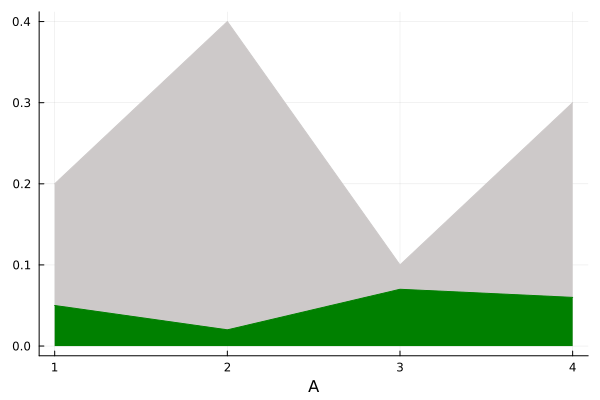

In [95]:
using Plots

# 3つの異なるデータセット
data1 = [0.2, 0.4, 0.1, 0.3]
data2 = [0.5, 0.2, 0.7, 0.6] ./ 10
data3 = [0.6, 0.8, 0.3, 0.5]

p = plot(xlabel="A")
plot!(p, color=:snow3, label="Grass")
# グラフの設定
plot!(p, data1, fillrange=0, color=:snow3, label="")

# Layer 2のデータを重ねる
plot!(p, data2, fillrange=0, color=:green,  label="")

# Layer 3のデータを重ねる
#plot!(data3, fillrange=0, fillalpha=0.3, label="Layer 3", color=:red)

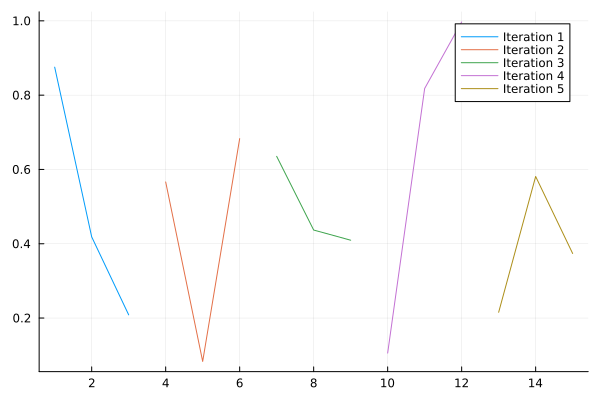

In [91]:
using Plots

# tの定義
t = 3  # 各反復の長さ
n_max = 5  # 繰り返し回数

# プロットを初期化
p = plot()

# 繰り返し処理
for n in 1:n_max
    # arrayの更新（例：ランダムなデータを使う）
    array = rand(t)  # arrayは1からtまでのインデックスを持つ
    
    # 横軸の範囲を(n-1)*t+1からn*tに設定
    x_range = (n-1)*t + 1 : n*t  # x_rangeを調整
    
    # arrayのインデックスを適切にずらしてプロット
    plot!(x_range, array, label="Iteration $n")
end

# 最終的なプロット表示
display(p)

In [48]:
a = zeros((1,2))

1×2 Matrix{Float64}:
 0.0  0.0

In [57]:
a = [
    1.0 4.0
    2.0 5.0
    3.0 6.0
]
b = [
    1.0
    2.0
    3.0
]

a ./= b

3×2 Matrix{Float64}:
 1.0  4.0
 1.0  2.5
 1.0  2.0

In [10]:
steps = 8640 * 3 + 2809
steps / (24 * 365)

3.279566210045662

# Moon included

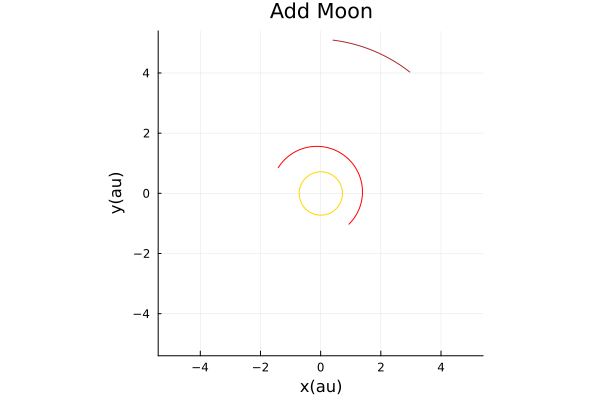

Simulated in  0.017027 seconds (294.56 k allocations: 35.412 MiB, 9.86% gc time)


In [ ]:
using LinearAlgebra
using Statistics
using JSON
using HDF5
using Plots

#=
length:km, mass:kg, time:s, angle:rad(deg in json)
(interval must be a multiple of dt, tEnd must be a multiple of interval)
=#

COLORS_DEF = [:orange, :black, :gold, :blue, :red, :brown, :bisque4, :gray, :blue, :black] #惑星の色
G = 6.67430e-20 #gravitational constant (G)
AU = 1.495978e8 #AU

# <---N body simulation--->
# get acc
function getAcc(pos, mass , G)
    x = pos[:,1,1]
    y = pos[:,2,1]
    z = pos[:,3,1]

    #Distance between celestial bodies
    dx = x' .- x
    dy = y' .- y
    dz = z' .- z

    #Inverse of the cube of the distance
    inv_r3 = (dx.^2 .+ dy.^2 .+ dz.^2 .+ 1.0e-15).^(-1.5)

    #acc
    ax = G * (dx .* inv_r3) * mass
    ay = G * (dy .* inv_r3) * mass
    az = G * (dz .* inv_r3) * mass

    return hcat(ax,ay,az)
end
function nBodySave(N, mass, pos, vel, tEnd, dt, chunk_size, title, range)
    vel .-= mean(mass .* vel) / mean(mass) #center of mass system
    acc = getAcc(pos, mass, G)
    Nt = Int(ceil(tEnd/dt)) #number of steps
    p = scatter([], [], xlims=(-range,range), ylims=(-range,range), title=title, xlabel="x(au)", ylabel="y(au)", aspect_ratio=:equal, legend=false)
    print("Simulated in")
    poses_nbody_save = zeros((N,3,chunk_size)) #Initial positions are not included
    @time for chunk in 1:Int(Nt/chunk_size)
        for i in 1:chunk_size
            vel += acc * dt/2.0
            pos += vel * dt
            acc = getAcc( pos, mass, G)
            vel += acc * dt/2.0
            poses_nbody_save[:,:,i] = pos
        end
        for i in 2:N 
            X = poses_nbody_save[i,1,:] ./ AU
            Y = poses_nbody_save[i,2,:] ./ AU
            plot!(p, X, Y, color=colors[i])
        end
    end
    return p
end

#Abbreviations list for the function below
abbreviations = Dict(
    "sun" => "sun", "mercury" => "mer", "venus" => "ven",
    "earth" => "ear", "mars" => "mar", "jupiter" => "jup",
    "saturn" => "sat", "uranus" => "ura", "neptune" => "nep"
)

#Load pos and vel from json
function loadData(key, epoch)
    file = JSON.parsefile("../Resources/nasa_pos_data.json")
    data = file[epoch][key]
    pos = [
        data["x"],
        data["y"],
        data["z"]
    ]
    vel = [
        data["vx"],
        data["vy"],
        data["vz"]
    ]
    return pos, vel, data["mass"]
end

function main(bodies, exclude=false)
    EPOCH = "2024-04-01"

    N = length(bodies) #The number of bodies
    if exclude
        N = NUMBER_OF_BODIES - N
    end
    mass = zeros(N) #List of mass
    pos = zeros((N,3)) #List of initial positions
    vel = zeros((N,3)) #List of initial velocities
    
    # 2.Calculate initial positions and velocities of the planets
    next = 1
    for i in 1:NUMBER_OF_BODIES
        is_included = PLANETS[i] in bodies
        if (is_included&!exclude)|(!is_included&exclude) # XOR
            pos[next,:], vel[next,:], mass[next] = loadData(PLANETS[i], EPOCH)
            colors[next] = COLORS_DEF[i]
            next += 1
        end
    end

    # 3.Simulate the motions of planets
    tEnd = 60.0 * 60.0 * 24.0 * 360 * 1 #Endtime
    dt = 60.0 * 60.0 #Delta time
    p = nBodySave(N, mass, pos, vel, tEnd, dt, 8640, "Add Moon", 5.4)
    display(p)
end

NUMBER_OF_BODIES = 10
PLANETS = ["sun", "mercury", "venus", "earth", "mars", "jupiter", "saturn", "uranus", "neptune", "moon"]
colors = Vector{Symbol}(undef,NUMBER_OF_BODIES)

main(
    ["sun", "venus", "mars", "jupiter", "saturn"],
    false
)
